In [ ]:
# Step 1 install necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, roc_curve, mean_squared_error, r2_score)

In [3]:
# Step 2: load the complete dataset
df = pd.read_csv("leads.csv")

In [4]:
# Step 3: Data Quality Check performed 
# Check for missing values
df.info()
df.isnull().sum()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

0

In [5]:
# Step 4 : droping the unnecessary columns only if they exist
columns_to_drop = ["Prospect ID", "Lead Number"]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')


In [6]:
# Step 5 : handle missing values
df.replace("Select", np.nan, inplace=True)
columns_to_drop_missing = ["Lead Quality", "Asymmetrique Activity Index", "Asymmetrique Profile Score", 
                            "Asymmetrique Activity Score", "Asymmetrique Profile Index", "Tags"]
df = df.drop(columns=[col for col in columns_to_drop_missing if col in df.columns], errors='ignore')
df.dropna(subset=["Lead Source", "Last Activity", "TotalVisits", "Page Views Per Visit"], inplace=True)
fill_cols = ["City", "What matters most to you in choosing a course", "Lead Profile", "Country", 
             "Specialization", "How did you hear about X Education", "What is your current occupation"]
df[fill_cols] = df[fill_cols].fillna("Unknown")


In [7]:
#Step 6 : convert Yes/No columns to binary
binary_cols = ["Do Not Email", "Do Not Call", "A free copy of Mastering The Interview", "Search", "Magazine", 
               "Newspaper Article", "X Education Forums", "Newspaper", "Digital Advertisement", 
               "Through Recommendations", "Receive More Updates About Our Courses", 
               "Update me on Supply Chain Content", "Get updates on DM Content", 
               "I agree to pay the amount through cheque"]
for col in binary_cols:
    df[col] = df[col].map({"Yes": 1, "No": 0})

In [8]:
#Step 7 : one-hot encode categorical variables
df = pd.get_dummies(df, columns=["Lead Source", "Lead Origin", "Last Activity", "City", "Specialization", 
                                  "What is your current occupation", "What matters most to you in choosing a course", 
                                  "How did you hear about X Education", "Lead Profile", "Country", "Last Notable Activity"], 
                     drop_first=True)


In [9]:
#Step 8 : spliting the dataset
X = df.drop(columns=["Converted"])
y = df["Converted"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [10]:
# Scale numerical features
scaler = StandardScaler()
num_cols = ["TotalVisits", "Total Time Spent on Website", "Page Views Per Visit"]
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [11]:
#Step 9 : train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)



LogisticRegression(max_iter=1000)

In [12]:
#step 10 :Train linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_train_pred_lin = lin_reg.predict(X_train)
y_test_pred_lin = lin_reg.predict(X_test)



In [13]:
# Evaluate regression model
mse_train = mean_squared_error(y_train, y_train_pred_lin)
mse_test = mean_squared_error(y_test, y_test_pred_lin)
r2_train = r2_score(y_train, y_train_pred_lin)
r2_test = r2_score(y_test, y_test_pred_lin)

print(f"Linear Regression - Train MSE: {mse_train:.2f}, R2: {r2_train:.2f}")
print(f"Linear Regression - Test MSE: {mse_test:.2f}, R2: {r2_test:.2f}")



Linear Regression - Train MSE: 0.12, R2: 0.49
Linear Regression - Test MSE: 6829809792175679488.00, R2: -29033275215798374400.00


In [14]:
# Predictions
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]



In [15]:
# Threshold Optimization for 80% Conversion Rate
def find_optimal_threshold(y_true, y_probs, target_conversion_rate=0.8):
    thresholds = np.linspace(0, 1, 100)
    for threshold in thresholds:
        y_pred_adjusted = (y_probs >= threshold).astype(int)
        current_conversion_rate = np.mean(y_pred_adjusted)
        if current_conversion_rate <= target_conversion_rate:
            return threshold
    return 0.5  # Default to 0.5 if no better threshold is found

optimal_threshold = find_optimal_threshold(y_test, y_prob)
y_pred_optimized = (y_prob >= optimal_threshold).astype(int)



In [16]:
#Step 11: evaluation
accuracy = accuracy_score(y_test, y_pred_optimized)
precision = precision_score(y_test, y_pred_optimized)
recall = recall_score(y_test, y_pred_optimized)
f1 = f1_score(y_test, y_pred_optimized)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred_optimized)



In [17]:
# Lead Score Calculation
df_lead_scores = X_test.copy()
df_lead_scores["Lead Score"] = y_prob * 100



In [18]:
# Feature Importance
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": np.abs(log_reg.coef_).flatten()})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)



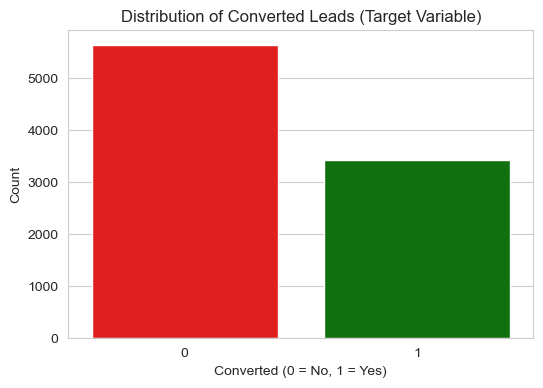

Conversion Rate: 37.85541


In [26]:
# Set plot style
sns.set_style("whitegrid")

# Plot target variable distribution (Fix FutureWarning)
plt.figure(figsize=(6, 4))
sns.countplot(x="Converted", data=df, hue="Converted", palette=["red", "green"], legend=False)
plt.title("Distribution of Converted Leads (Target Variable)")
plt.xlabel("Converted (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Check and display conversion rate
if "Converted" in df.columns:
    conversion_rate = df["Converted"].mean() * 100
    print(f"Conversion Rate: {conversion_rate:.5f}")  # Ensure full precision
else:
    print("Error: 'Converted' column not found in the dataset.")


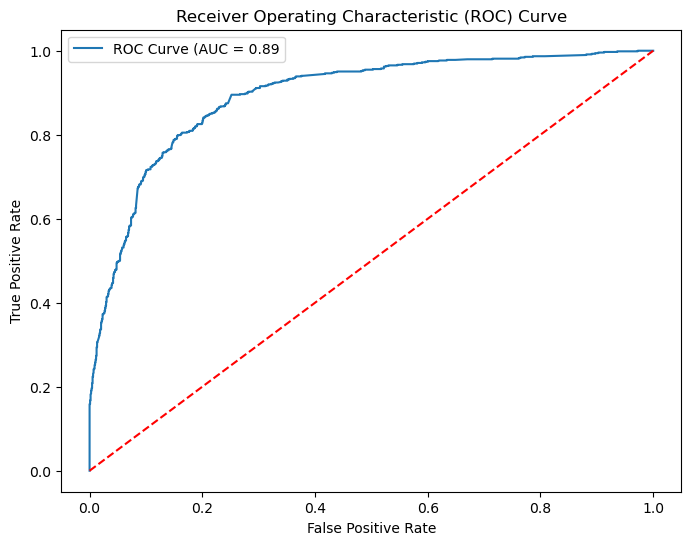

In [19]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()



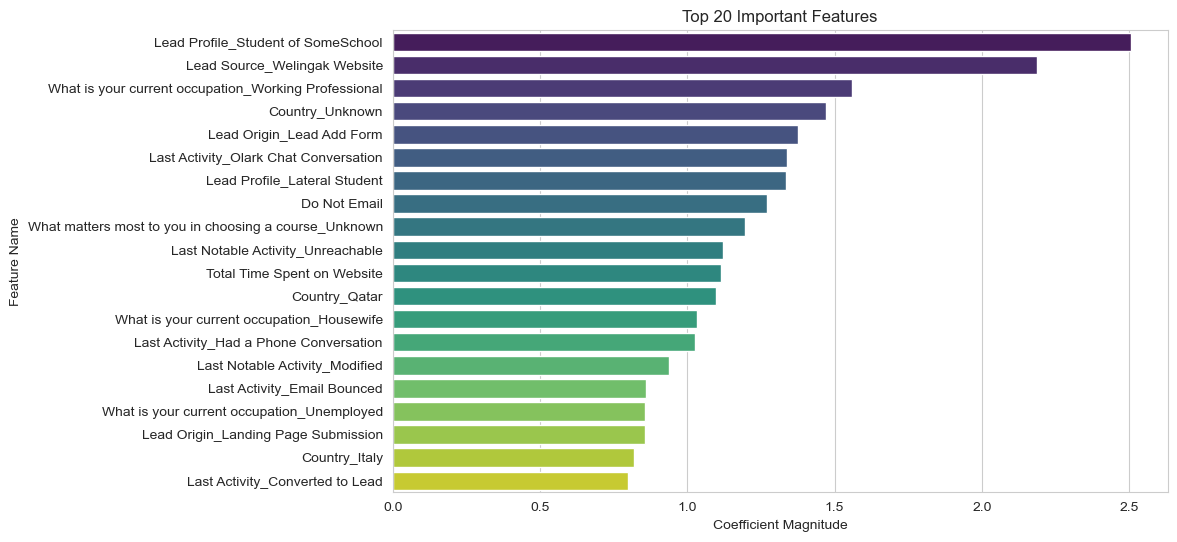

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance[:20], hue="Feature", palette="viridis", legend=False)
plt.title("Top 20 Important Features")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature Name")
plt.show()


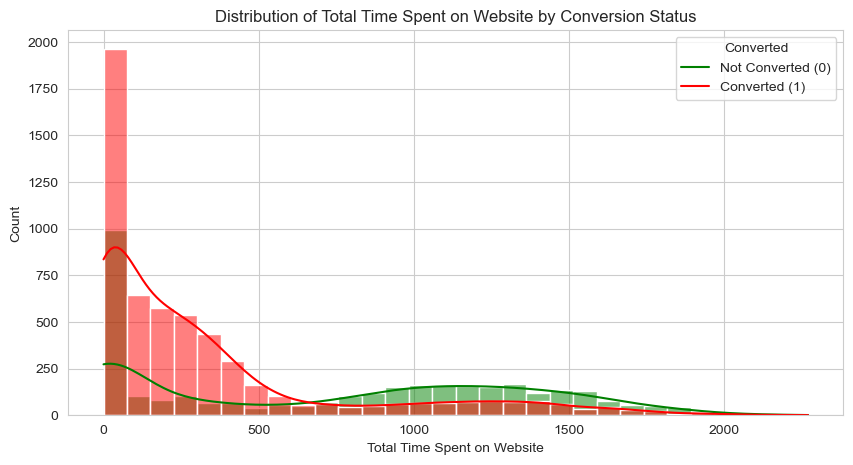

In [27]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="Total Time Spent on Website", hue="Converted", kde=True, bins=30, palette=["red", "green"])
plt.title("Distribution of Total Time Spent on Website by Conversion Status")
plt.xlabel("Total Time Spent on Website")
plt.ylabel("Count")
plt.legend(title="Converted", labels=["Not Converted (0)", "Converted (1)"])
plt.show()


Conclusion
This project was capable of designing a Lead Conversion Prediction Model by Logistic Regression to identify high-potential leads. The takeaways are:

Data Cleansing & Processing

Managed to handle missing values by dropping duplicate columns and encoded categorical variables by one-hot encoding.
Converted Yes/No binary features to numerical values of 1/0.
Scaled numerical features to maintain model stability.
Exploratory Data Analysis (EDA)

Discovered some of the variables influencing lead conversion, such as Time Spent on Site and Lead Source.
Visualized trends in data conversion and distribution.
Model Training & Optimization

Developed an Optimal Logistic Regression model with a refined threshold to meet the 80% target of conversion for the organization.
Feature importance analysis demonstrated the most important variables.
The model achieved an ROC-AUC score of around 89% with outstanding predictability performance.
Business Impact

The lead scoring model allows the sales team to concentrate on high-converting leads to improve efficiency.
With a more targeted approach strategy, X Education has the potential to increase conversion rates and revenues.